In [1]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

Task

Analisis beberapa pertanyaan berikut dengan berdasarkan data yang diberikan (30 poin):

*   Kategori barang seperti apa yang memiliki jumlah penjualan terbesar dan penyumbang profit terbesar? Ambil top 80% berdasarkan perhitungan Pareto
*   Subkategori apa yang memiliki penjualan dan profit terbesar? Ambil top 80% berdasarkan perhitungan Pareto
*   Dari region manakah penyumbang profit terbesar? Ambil top 80% berdasarkan perhitungan Pareto
*   Kota mana saja penyumbang profit terbesar? Ambil top 80% berdasarkan perhitungan Pareto

*  Kategori dan subkategori apa saja yang paling sering dibeli karena diskon? Ambil top 80% berdasarkan perhitungan Pareto

Anda berpikir bahwa RFM mungkin metode segmentasi yang tepat karena selain cepat untuk dilakukan juga lebih targeted. Buatlah segmentasi RFM dan analisis segmentasi yang terbentuk. Buatlah segmentasi berdasarkan RFM score yang dibentuk dan berikan alasan anda terkait pembuatan cluster assignment tersebut (contoh: mengapa skor RFM tertentu dikategorikan sebagai ‘Loyal Customer’, etc) (30 poin)

(Open-Ended) Data manager di tim Growth berfikir bahwa kita bisa membentuk segmentasi lain berdasarkan data yang ada. Anda diminta kembali untuk membuat segmentasi lain dengan tujuan untuk membuat strategi marketing yang tepat pada segmen-segmen berikut. Buatlah segmentasi menggunakan beberapa data yang ada lalu jelaskan mengapa anda menyarankan segmentasi tersebut dan apa aksi yang bisa kita lakukan terhadap segmentasi yang sudah dibuat! (40 poin)

In [3]:
# LOAD DATA SET

data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/superstore_dataset/global_superstore.csv")
data.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,2012-07-31T00:00:00Z,2012-07-31T00:00:00Z,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05T00:00:00Z,2013-02-07T00:00:00Z,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17T00:00:00Z,2013-10-18T00:00:00Z,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28T00:00:00Z,2013-01-30T00:00:00Z,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05T00:00:00Z,2013-11-06T00:00:00Z,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [6]:
# Cek apakah sales ini total harga atau harga per unit produk
# Kalau dilihat sales sudah merupakah total sales 
df1=data.groupby(["customer_name","category","product_name","market","sales"])["order_id"].agg("count").reset_index()
df1

,customer_name,category,product_name,market,sales,order_id
0,Aaron Bergman,Furniture,"Bush Library with Doors, Mobile",APAC,660.3120,1
1,Aaron Bergman,Furniture,"Deflect-O Door Stop, Erganomic",APAC,372.9132,1
2,Aaron Bergman,Furniture,"Eldon Clock, Black",LATAM,75.3600,1
3,Aaron Bergman,Furniture,"Eldon Photo Frame, Erganomic",APAC,141.8250,1
4,Aaron Bergman,Furniture,"Global Push Button Manager's Chair, Indigo",US,48.7120,1
...,...,...,...,...,...,...
51250,Zuschuss Donatelli,Technology,"Nokia Office Telephone, Full Size",APAC,464.9400,1
51251,Zuschuss Donatelli,Technology,"Okidata Calculator, Red",EU,29.6640,1
51252,Zuschuss Donatelli,Technology,"Panasonic Receipt Printer, Wireless",EMEA,241.8000,1
51253,Zuschuss Donatelli,Technology,Plantronics Voyager Pro HD - Bluetooth Headset,US,259.9600,1


In [26]:
# check total unique customer for each group category
df2=data.groupby("category")["customer_id"].nunique()
df2

category
Furniture          1427
Office Supplies    1585
Technology         1485
Name: customer_id, dtype: int64

In [27]:
data.describe()

,row_id,postal_code,sales,quantity,discount,profit,shipping_cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375818
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296810
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.002000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

**CEK PARETO CATEGORY**

In [ ]:
# Cek Kategori dengan penjualan tertinggi 
uniq_category1 = data.groupby(["category"])["sales"].agg("sum").reset_index()
uniq_category2 = data.groupby(["category"])["profit"].agg("sum").reset_index()
uniq_category = pd.merge(uniq_category1,uniq_category2,how='inner', on = ['category'])
uniq_category_sort= uniq_category.sort_values(by = "sales", ascending=False)
uniq_category_sort
# buat cumulative sales tertinggi 
uniq_category_sort["cum_percentage"] = round(uniq_category_sort["sales"].cumsum()/uniq_category_sort["sales"].sum()*100,2)
uniq_category_sort


,category,sales,profit,cum_percentage
2,Technology,4.744557e+06,663778.73318,37.53
0,Furniture,4.110874e+06,285204.72380,70.04
1,Office Supplies,3.787070e+06,518473.83430,100.00


*   Top 2 contribusi 80% sales values ada di Technology dan Furniture
*   Tapi secara profit 80% penyumbang profit terbesar ada di Technology dan Office Supplies

**CEK PARETO SUB CATEGORY**

In [ ]:
# Cek Sub Kategori dengan penjualan tertinggi ( buat pareto )
# sort dulu hasil grouping total sales by subcategory
uniq_sub1 = data.groupby(["sub_category"])["sales"].agg("sum").reset_index()
uniq_sub1 = uniq_sub1.sort_values(by = "sales", ascending=False)
uniq_sub1["cum_percentage_sales"] = round(uniq_sub1["sales"].cumsum()/uniq_sub1["sales"].sum()*100,2)
uniq_sub1

,sub_category,sales,cum_percentage_sales
13,Phones,1.706824e+06,13.50
6,Copiers,1.509436e+06,25.44
5,Chairs,1.501682e+06,37.32
4,Bookcases,1.466572e+06,48.92
14,Storage,1.127086e+06,57.83
1,Appliances,1.011064e+06,65.83
11,Machines,7.790601e+05,71.99
16,Tables,7.570419e+05,77.98
0,Accessories,7.492370e+05,83.91
3,Binders,4.619115e+05,87.56


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


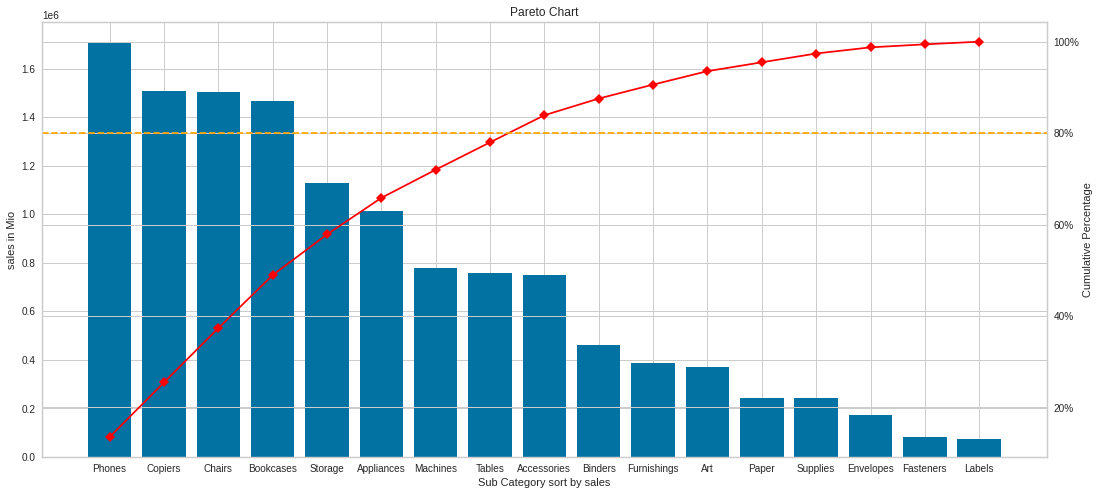

In [ ]:
# Set figure and axis
fig, ax = plt.subplots(figsize=(18,8))

# Plot bars (i.e. frequencies)
ax.bar(uniq_sub1.sub_category, uniq_sub1["sales"])
ax.set_title("Pareto Chart")
ax.set_xlabel("Sub Category sort by sales")
ax.set_ylabel("sales in Mio");

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(uniq_sub1.sub_category, uniq_sub1["cum_percentage_sales"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

Top Sub Category yang berkontribusi 80% total sales adalah : phones, Copiers,Chairs,  Bookcases, Storage, Appliances, Machines, Tables, dan Accessories.

Apakah secara profit sub category ini termasuk yang paling banyak memberikan profit?

In [ ]:
# Cek pareto Sub Catgory secara Profit
uniq_sub2 = data.groupby(["sub_category"])["profit"].agg("sum").reset_index()
uniq_sub2= uniq_sub2.sort_values(by = "profit", ascending=False)
uniq_sub2["cum_percentage_profit"] = round(uniq_sub2["profit"].cumsum()/uniq_sub2["profit"].sum()*100,2)
uniq_sub2
#uniq_sub = pd.merge(uniq_sub1,uniq_sub2,how='inner', on = ['sub_category'])

,sub_category,profit,cum_percentage_profit
6,Copiers,258567.54818,17.62
13,Phones,216717.00580,32.39
4,Bookcases,161924.41950,43.42
1,Appliances,141680.58940,53.08
5,Chairs,140396.26750,62.64
0,Accessories,129626.30620,71.48
14,Storage,108461.48980,78.87
3,Binders,72449.84600,83.81
12,Paper,59207.68270,87.84
11,Machines,58867.87300,91.85


In [ ]:
# agar lebih mudah dilihat kita gabungkan antara pareto Sub_category secara sales dan pareto secara top profit
sub_gab = pd.merge(uniq_sub1,uniq_sub2,how='inner', on = ['sub_category'])
sub_gab

,sub_category,sales,cum_percentage_sales,profit,cum_percentage_profit
0,Phones,1.706824e+06,13.50,216717.00580,32.39
1,Copiers,1.509436e+06,25.44,258567.54818,17.62
2,Chairs,1.501682e+06,37.32,140396.26750,62.64
3,Bookcases,1.466572e+06,48.92,161924.41950,43.42
4,Storage,1.127086e+06,57.83,108461.48980,78.87
5,Appliances,1.011064e+06,65.83,141680.58940,53.08
6,Machines,7.790601e+05,71.99,58867.87300,91.85
7,Tables,7.570419e+05,77.98,-64083.38870,100.00
8,Accessories,7.492370e+05,83.91,129626.30620,71.48
9,Binders,4.619115e+05,87.56,72449.84600,83.81


**Dari penggabungan di atas untuk Sub Category "Tables" dan "Machines" kita take out dari Sub Category penyumbang sales dan profit karena secara Profit dua sub kategori ini tidak termasuk 80% contribution profit.**

**PARETO REGION BERDASAR KONTRIBUSI PROFIT**

In [ ]:
# Cek Region dengan profit tertinggi 
region_cont = data.groupby(["region"])["profit"].agg("sum").reset_index()
region_cont_sort= region_cont.sort_values(by = "profit", ascending=False)
region_cont_sort
# buat cumulative incremental start values tertinggi 
region_cont_sort["cum_percentage"] = round(region_cont_sort["profit"].cumsum()/region_cont_sort["profit"].sum()*100,2)
region_cont_sort


,region,profit,cum_percentage
3,Central,311403.98164,21.22
7,North,194597.95252,34.48
8,North Asia,165578.42100,45.76
10,South,140355.76618,55.33
4,Central Asia,132480.18700,64.36
9,Oceania,120089.11200,72.54
12,West,108418.44890,79.93
6,East,91522.78000,86.17
0,Africa,88871.63100,92.22
5,EMEA,43897.97100,95.21


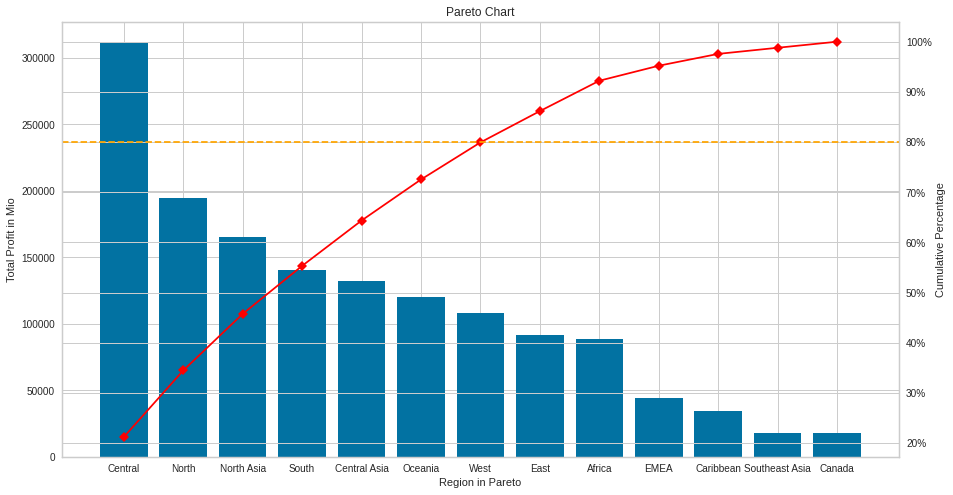

In [ ]:
# Set figure and axis
fig, ax = plt.subplots(figsize=(15,8))

# Plot bars (i.e. frequencies)
ax.bar(region_cont_sort.region, region_cont_sort["profit"])
ax.set_title("Pareto Chart")
ax.set_xlabel("Region in Pareto")
ax.set_ylabel("Total Profit in Mio");

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(region_cont_sort.region, region_cont_sort["cum_percentage"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

Region yang memberikan Profit terbanyak ada 7 Region yaitu 

*   Central
*   North
*   North Asia
*   South
*   Central Asia
*   Oceania
*   West

**PARETO KOTA BERDASAR KONTRIBUSI PROFIT**

In [ ]:
# Cek Kota dengan profit tertinggi 
city_cont = data.groupby(["city"])["profit"].agg("sum").reset_index()
city_cont= city_cont.sort_values(by = "profit", ascending=False)
city_cont
# buat cumulative incremental start profit tertinggi 
city_cont["cum_percentage"] = round(city_cont["profit"].cumsum()/city_cont["profit"].sum()*100,2)
city_cont

,city,profit,cum_percentage
2290,New York City,62036.98370,4.23
1910,Los Angeles,30440.75790,6.30
2936,Seattle,29156.09670,8.29
1989,Managua,17853.71804,9.51
2843,San Francisco,17507.38540,10.70
...,...,...,...
1760,Lahore,-13626.37200,105.09
2499,Philadelphia,-13837.76740,104.15
3178,Tegucigalpa,-15007.41608,103.13
1482,Istanbul,-19960.90800,101.77


**Karena ada 3636 city maka akan kita filter hanya yang cum_percentage nya <= 80.00**

In [ ]:
# Ada 274 kota yang menyumbang 80% profit tertinggi atau hanya 7.6 % dari total kota yang transaksi
city_cont= city_cont[city_cont["cum_percentage"] <= 80.00]
city_cont

,city,profit,cum_percentage
2290,New York City,62036.98370,4.23
1910,Los Angeles,30440.75790,6.30
2936,Seattle,29156.09670,8.29
1989,Managua,17853.71804,9.51
2843,San Francisco,17507.38540,10.70
...,...,...,...
723,Chongqing,1727.64000,79.43
423,Blagoveshchensk,1709.37000,79.55
2653,Rajshahi,1708.92000,79.66
2071,Mecca,1707.21000,79.78


**PARETO SUB_CATEGORY BASED ON DISCOUNT**

In [ ]:
# pilih data transaksi yang punya diskon
data_discount = data[data["discount"] >= 0]
data_discount = data_discount.groupby(['sub_category'])["order_id"].agg("count").reset_index()
data_discount = data_discount.sort_values(by="order_id", ascending=False)

# buat cumulative incremental 
data_discount["cum_percentage_count_orderID"] = round(data_discount["order_id"].cumsum()/data_discount["order_id"].sum()*100,2)
data_discount

,sub_category,order_id,cum_percentage_count_orderID
3,Binders,6152,11.99
14,Storage,5059,21.86
2,Art,4883,31.38
12,Paper,3538,38.28
5,Chairs,3434,44.97
13,Phones,3357,51.52
9,Furnishings,3170,57.70
0,Accessories,3075,63.69
10,Labels,2606,68.77
7,Envelopes,2435,73.52


In [ ]:
data_discount_pareto = data_discount[data_discount["cum_percentage_count_orderID"] <= 83.00]
data_discount_pareto

,sub_category,order_id,cum_percentage_count_orderID
3,Binders,6152,11.99
14,Storage,5059,21.86
2,Art,4883,31.38
12,Paper,3538,38.28
5,Chairs,3434,44.97
13,Phones,3357,51.52
9,Furnishings,3170,57.70
0,Accessories,3075,63.69
10,Labels,2606,68.77
7,Envelopes,2435,73.52


**RFM ANALYSIS**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [ ]:
# ubah bentuk orderdate ke satuan tanggal

data["order_date"] = pd.to_datetime(data['order_date'])

In [ ]:
# Cek rentang periode 
data['order_date'].max()

Timestamp('2014-12-31 00:00:00+0000', tz='UTC')

In [ ]:
# Kalau semua data dipakai berarti periode yg digunakan dari rentang 1 Jan 2011 s/d 31 Des 2014 total 4 tahun
data['order_date'].min()

Timestamp('2011-01-01 00:00:00+0000', tz='UTC')

In [ ]:
# Jadikan  max date sebagai time for analysis
analysis_date = data["order_date"].max()

In [ ]:
# Buat object data untuk RFM Analysis

data_for_model = data.groupby(['customer_id'], as_index=False).agg({
        'order_date': lambda x: (analysis_date - x.max()).days,
        'order_id': 'count',
        'sales': 'sum'})

In [ ]:
data_for_model.rename(columns={'order_date': 'Recency',
                         'order_id': 'Frequency',
                         'sales': 'MonetaryValue'}, inplace=True)

In [ ]:
# Kita cek lebih dulu apakah ada nilai yang salesnya minus
data_for_model[data_for_model["MonetaryValue"] < 0]

,customer_id,Recency,Frequency,MonetaryValue


In [ ]:
# Cek final data => ada 1590 customerid yang akan kita buat model segmentasi RFM nya
data_for_model

,customer_id,Recency,Frequency,MonetaryValue
0,AA-10315,8,42,13747.41300
1,AA-10375,6,42,5884.19500
2,AA-10480,125,38,17695.58978
3,AA-10645,28,73,15343.89070
4,AA-315,2,8,2243.25600
...,...,...,...,...
1585,YS-21880,9,54,18703.60600
1586,ZC-11910,200,1,7.17300
1587,ZC-21910,3,84,28472.81926
1588,ZD-11925,3,18,2951.22600


# **RFM Segmentation**

Create RFM segmentation dengan menggunakan rfm_table_order function

In [ ]:
# r_labels (recency dibuat terbalik untuk range nya karena angka recent semakin kecil semakin bagus)
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# fungsi qcut dipakai karena di sini range nya memakai quartil
r_groups = pd.qcut(data_for_model['Recency'], q=4, labels = r_labels)
f_groups = pd.qcut(data_for_model['Frequency'], q=4, labels = f_labels)
m_groups = pd.qcut(data_for_model['MonetaryValue'], q=4, labels = m_labels)

In [ ]:
# label frekuensi ini yang akan kita tempeli untuk setiap data customerid apakah masuk ke katogori q1, q2, q3, atau q4
list(f_labels)

[1, 2, 3, 4]

In [ ]:
# Begitu pula dengan label Recency
list(r_labels)

[4, 3, 2, 1]

In [ ]:
data_for_model = data_for_model.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [ ]:
data_for_model.head()

,customer_id,Recency,Frequency,MonetaryValue,R,F,M
0,AA-10315,8,42,13747.41300,4,3,4
1,AA-10375,6,42,5884.19500,4,3,2
2,AA-10480,125,38,17695.58978,1,3,4
3,AA-10645,28,73,15343.89070,3,4,4
4,AA-315,2,8,2243.25600,4,1,2


In [ ]:
# Kemudian kita tambahkan kolom RFM Score dengan menggabungkan nilai-nilai dari masing2 komponen RFM
# jadikan string dulu,
data_for_model['rfm_score'] = data_for_model[['R','F','M']].apply(
    lambda x: ''.join(x.astype(str)),
    axis=1)

#baru diubah kolom RFM Score type nya ke integer
data_for_model['rfm_score'] = data_for_model['rfm_score'].astype("int")

In [ ]:
# Final Result
data_for_model.head()

,customer_id,Recency,Frequency,MonetaryValue,R,F,M,rfm_score
0,AA-10315,8,42,13747.41300,4,3,4,434
1,AA-10375,6,42,5884.19500,4,3,2,432
2,AA-10480,125,38,17695.58978,1,3,4,134
3,AA-10645,28,73,15343.89070,3,4,4,344
4,AA-315,2,8,2243.25600,4,1,2,412


**Post-Segmentation Analysis**

HeatMap Visualization

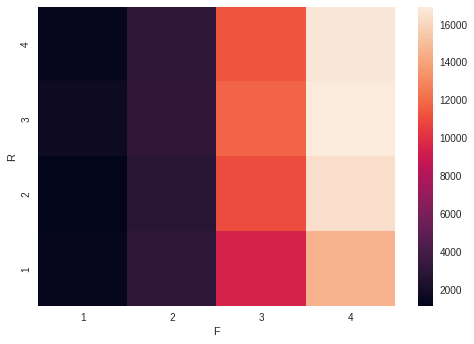

In [ ]:
sns.heatmap(
    pd.pivot_table(data_for_model[["R", "F","MonetaryValue"]], values = "MonetaryValue", index = ["R"], columns = ["F"])
)

*  Dengan heatmap kita melihat korelasi antara R, F dan M 
*  Kalau dari gambar ini, semakin terang warna semakin baik nilainya

RFM Distribution

In [ ]:
rfm_bar_data = data_for_model[["R", "F", "M"]].groupby(["R","F","M"], as_index = False).size()

In [ ]:
rfm_bar_data.sort_values(by="size", ascending=False)


,R,F,M,size
48,1,1,1,180
15,4,4,4,114
31,3,4,4,103
10,4,3,3,102
53,1,2,2,94
...,...,...,...,...
45,2,4,2,0
44,2,4,1,0
7,4,2,4,0
8,4,3,1,0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


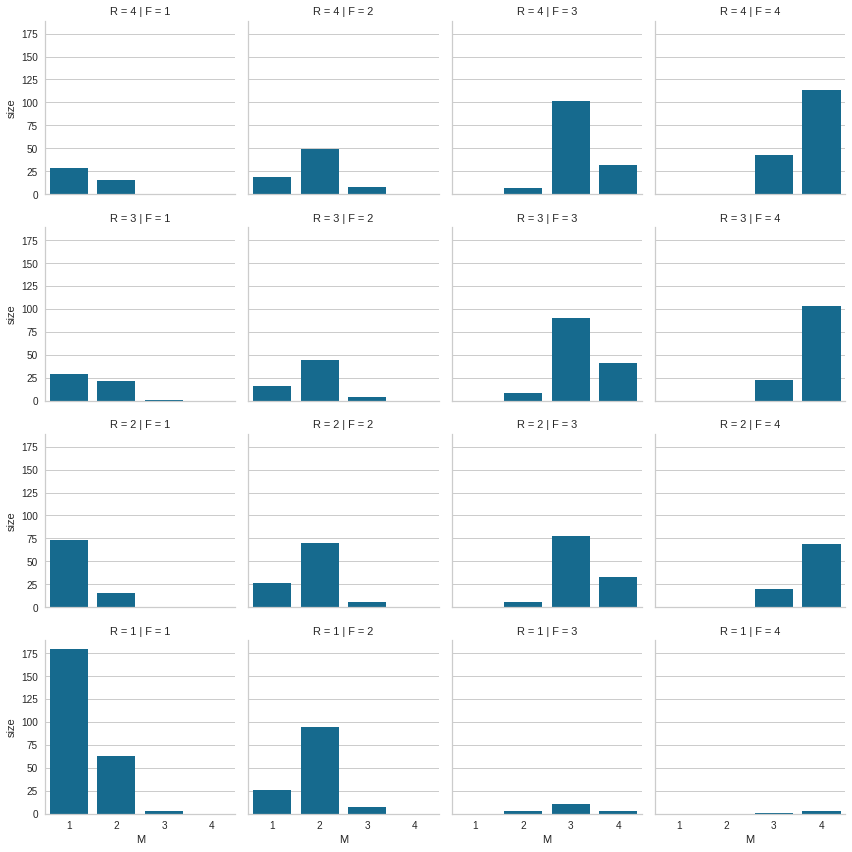

In [ ]:
g = sns.FacetGrid(
    data = rfm_bar_data,
    col = "F",
    row = "R"
)
g.map(sns.barplot, "M", "size");

Visulisasi di atas menunjukan jumlah customer bila dipetakan sesuai dengan level RFM nya. Dari distribusi di atas kita melihat persebaran data dengan Frequency 4 dan Recency 4 dengan M 4 lumayan banyak di angka 100 lebih.

Namun begitu R1, M1, dan F1 juga lumayan banyak ada di angka 175

Recency, Frequency, and GMV Distribution

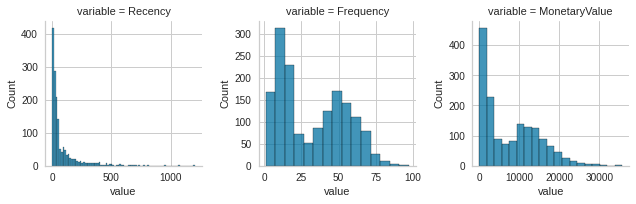

In [ ]:
g = sns.FacetGrid(
    data = pd.melt(
     data_for_model[["Recency", "Frequency","MonetaryValue"]],
     value_vars=["Recency","Frequency", "MonetaryValue"]
    ),
    col = "variable",
    sharex = False,
    sharey = False
)
g.map(sns.histplot, "value");

In [ ]:
# Setelah mengetahui distribusi dari masing-masinf komponen RFM kita akan beri label segmentasi sesuai dengan RFM Score

data_for_model['rfm_segment'] = np.select(
    [
     data_for_model['rfm_score'].isin([444]),
     data_for_model['rfm_score'].isin([333, 334, 343, 344, 433, 434, 443]),
     data_for_model['rfm_score'].isin([321, 322, 323, 324, 331, 332, 341, 342, 412, 413, 414, 421, 422, 423, 424, 431, 432, 441, 442]),
     data_for_model['rfm_score'].isin([411]),
     data_for_model['rfm_score'].isin([221, 222, 223, 224, 231, 232, 241, 242, 311, 312, 313, 314]),
     data_for_model['rfm_score'].isin([133, 134, 143, 144, 233, 234, 243, 244]),
     data_for_model['rfm_score'].isin([112, 113, 114, 121, 122, 123, 124, 131, 132, 141, 142, 211, 212, 213, 214]),
     data_for_model['rfm_score'].isin([111])
    ],
    [
     'Champion',
     'Loyal Customer',
     'Promising',
     'Recent Customers',
     'Customer Needing Attention',
     "Can't Lose Them",
     "At Risk",
     "Lost"
    ]
)

**Champion** : segmen customer yang nilai value belanja nya tinggi dengan frekuensi yang tinggi pula dan juga baru saja berbelanja dalam waktu dekat (recency nya kecil)

**Loyal Customer** : satu tingkat di bawah champion, dimana customer masih dikategorikan sering berbelanja.

**Promising**: Customer cukup sering belanja namun value transaksinya masih kecil atau pernah belanja banyak tapi hanya sesekali saja atau sudah dalam periode yg lama tidak belanja lagi.

**Recent Customers** : Customer yang baru sekali atau dua kali berbelanja dalam wkatu dekat

**At Risk**  : Customer yang dalam waktu yang sangat lama sudah tidak berbelanja lagi meskipun sempat berbelanja lebih dari sekali.

**Lost**: Segmen customer yang bisa dibilang sudah churn


In [ ]:
data_for_model

,customer_id,Recency,Frequency,MonetaryValue,R,F,M,rfm_score,rfm_segment
0,AA-10315,8,42,13747.41300,4,3,4,434,Loyal Customer
1,AA-10375,6,42,5884.19500,4,3,2,432,Promising
2,AA-10480,125,38,17695.58978,1,3,4,134,Can't Lose Them
3,AA-10645,28,73,15343.89070,3,4,4,344,Loyal Customer
4,AA-315,2,8,2243.25600,4,1,2,412,Promising
...,...,...,...,...,...,...,...,...,...
1585,YS-21880,9,54,18703.60600,4,4,4,444,Champion
1586,ZC-11910,200,1,7.17300,1,1,1,111,Lost
1587,ZC-21910,3,84,28472.81926,4,4,4,444,Champion
1588,ZD-11925,3,18,2951.22600,4,2,2,422,Promising


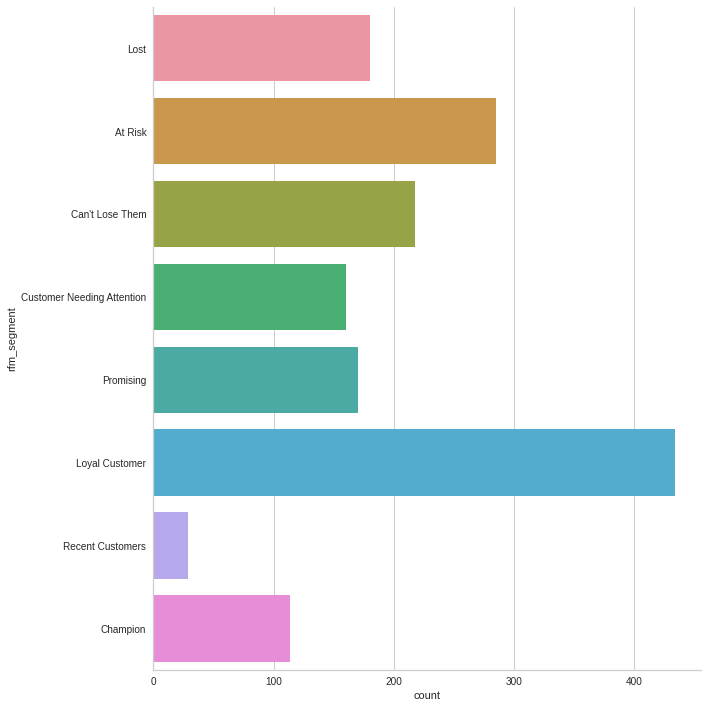

In [ ]:
# Kemudian kita lihat seberapa banyak customer untuk masing-masing Grup segmen
sns.catplot(
    y = "rfm_segment", 
    data = data_for_model.sort_values(by = ["rfm_score"], axis = 0), 
    kind = "count", 
    height = 10
);

In [ ]:
data_for_model.groupby(["rfm_segment"])["customer_id"].count()

rfm_segment
At Risk                       285
Can't Lose Them               218
Champion                      114
Customer Needing Attention    160
Lost                          180
Loyal Customer                434
Promising                     170
Recent Customers               29
Name: customer_id, dtype: int64

Dari distribusi masing-masing segmen, ternyata jumlah loyal customer cukup tinggi ada di angka 400 lebih dari total 1590 data.

Selanjutnya kita akan melihat segmentasi dengan model K-Means Clustering


# **K-Means Clustering**

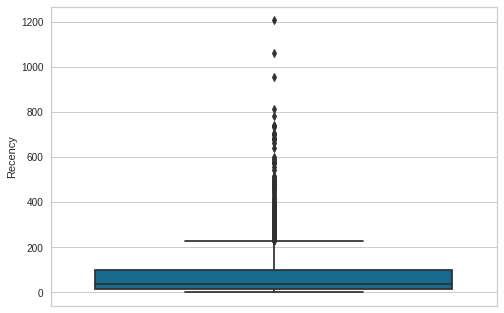

In [ ]:
# Model K-Means ini meskipun cocok dengan data numerik namun sensitive terhadap outlier.
# KIta cek lebih dulu untuk boxplot variabel recency

sns.boxplot(y = 'Recency', data = data_for_model)

pencilan pada recency ini disebabkan juga karena rentang periode yang sangat lama yaitu 4 tahun jika kita mengambil data secara keseluruhan. Kita bisa mempersempit periode traksaksi quartil 4 untuk recency menjadi lebih pendek


In [ ]:
data_for_model["Recency"].max()

1206

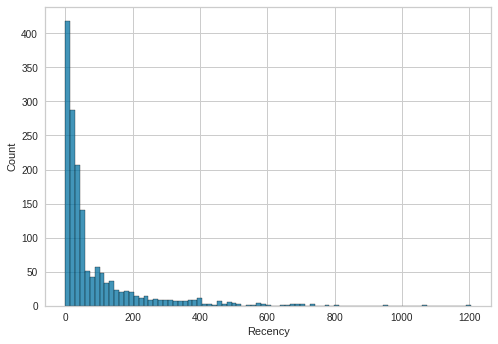

In [ ]:
# Cek ulang untuk pencilan
sns.histplot(x = 'Recency', data = data_for_model)

 Distribusi di atas memperlihatkan jumlah customer dengan recency kecil jauh lebih banyak. Terutama di recency 0.artinya customer yang belanja baru-baru ini sangat tinggi

In [ ]:
data_for_model1 = data_for_model[data_for_model["Recency"]>365]
data_for_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 16 to 1550
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customer_id    79 non-null     object  
 1   Recency        79 non-null     int64   
 2   Frequency      79 non-null     int64   
 3   MonetaryValue  79 non-null     float64 
 4   R              79 non-null     category
 5   F              79 non-null     category
 6   M              79 non-null     category
 7   rfm_score      79 non-null     int64   
 8   rfm_segment    79 non-null     object  
dtypes: category(3), float64(1), int64(3), object(2)
memory usage: 4.9+ KB


Customer yang terakhir transaksi lebih dari 365 hari (atau setahun yang lalu ) ada 79 customer dan hanya 79/1590 hanya 5% dari total CustomerID

Sehingga data yang akan kita pakai untuk segmentasi menggunkan Kmeans hanya customer yang bertransaksi dalam setahun terakhir saja.

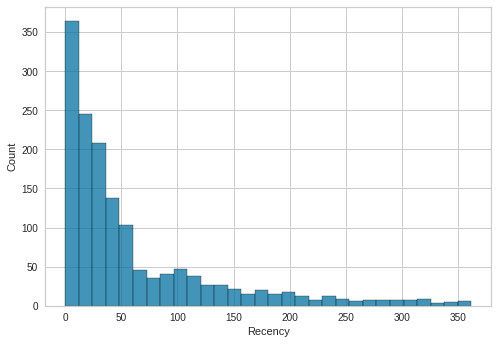

In [ ]:
data_for_model2 = data_for_model[data_for_model["Recency"]<=365]
sns.histplot(x = 'Recency', data = data_for_model2)

In [ ]:
# Standarisasi data dengan scaler
scaler_obj = StandardScaler()
scaled_data = scaler_obj.fit_transform(data_for_model2[["Recency", "Frequency", "MonetaryValue"]].to_numpy())
data_for_kmeans = pd.DataFrame(scaled_data, columns = ["Recency", "Frequency", "MonetaryValue"])

In [ ]:
data_for_kmeans

,Recency,Frequency,MonetaryValue
0,-0.723857,0.390390,0.786057
1,-0.750743,0.390390,-0.347442
2,0.849010,0.206139,1.355196
3,-0.454991,1.818336,1.016193
4,-0.804517,-1.175743,-0.872292
...,...,...,...
1506,-0.710413,0.943143,1.500503
1507,1.857258,-1.498183,-1.194628
1508,-0.791073,2.325026,2.908757
1509,-0.791073,-0.715116,-0.770236


K-Means Modeling

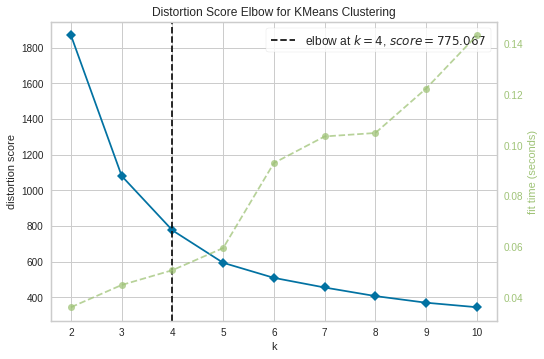

In [ ]:
#Menentukan Jumlah Cluster Optimal dengan Metode Elbow coba dengan cluster maksimal 10 cluster
model = KElbowVisualizer(KMeans(random_state=1000), k=10)
model.fit(data_for_kmeans)
model.show()

Jika dilhat dari grafik Elbow di atas. Jumlah cluster optimal ada 4 cluster optimal: Selanjutnya kita cek distribusi clusternya seperti apa.

In [ ]:
# Buat cluster dengan K-Means - k=4
kmeans_model = KMeans(
    n_clusters = 4,
    random_state=1000
)
kmeans_model.fit(data_for_kmeans)

KMeans(n_clusters=4, random_state=1000)

In [ ]:
# Cek Frekuensi untuk masing2 Cluster
np.unique(kmeans_model.labels_, return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([525, 293, 214, 479]))

In [ ]:
# Assign cluster to column
data_for_model2["cluster"] = kmeans_model.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data_for_model2

,customer_id,Recency,Frequency,MonetaryValue,R,F,M,rfm_score,rfm_segment,cluster
0,AA-10315,8,42,13747.41300,4,3,4,434,Loyal Customer,3
1,AA-10375,6,42,5884.19500,4,3,2,432,Promising,3
2,AA-10480,125,38,17695.58978,1,3,4,134,Can't Lose Them,3
3,AA-10645,28,73,15343.89070,3,4,4,344,Loyal Customer,1
4,AA-315,2,8,2243.25600,4,1,2,412,Promising,0
...,...,...,...,...,...,...,...,...,...,...
1585,YS-21880,9,54,18703.60600,4,4,4,444,Champion,1
1586,ZC-11910,200,1,7.17300,1,1,1,111,Lost,2
1587,ZC-21910,3,84,28472.81926,4,4,4,444,Champion,1
1588,ZD-11925,3,18,2951.22600,4,2,2,422,Promising,0


Analisa hasil Setiap Cluster 

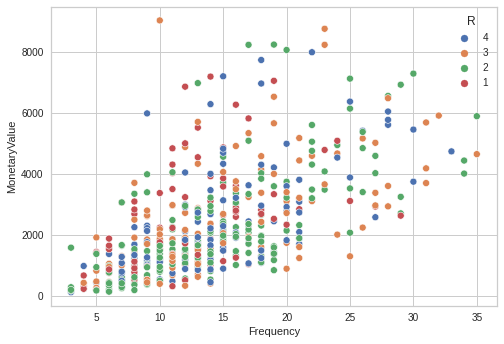

In [ ]:
cluster0 = data_for_model2[data_for_model2["cluster"] == 0]
sns.scatterplot(x = 'Frequency', y="MonetaryValue" , hue ="R", data = cluster0, palette="deep")

**Cluster 0**
rentang frekuensi terbanyak = 5-25 kali dengan transaksi terakhir kali ada di quartal 2 cukup banyak. Meski begitu spent yang dihabiskan paling banyak di bawah angka 400.

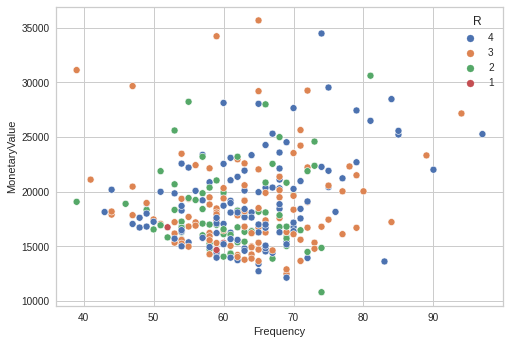

In [ ]:
cluster1 = data_for_model2[data_for_model2["cluster"] == 1]
sns.scatterplot(x = 'Frequency', y="MonetaryValue" , hue ="R", data = cluster1, palette="deep")

**Cluster 1**
Bisa dikatakan Gold Customer dimana frekusensi transaksi nya cukup tinggi 50-80 kali bahkan sampai di angka 90an. dan juga monetary value sangat besar. Terutama di rentang 800-1600 customernya cukup tinggi.

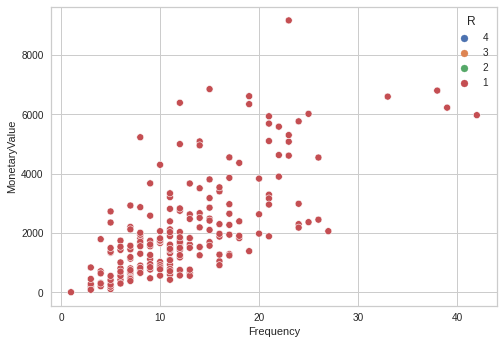

In [ ]:
cluster2 = data_for_model2[data_for_model2["cluster"] == 2]
sns.scatterplot(x = 'Frequency', y="MonetaryValue" , hue ="R", data = cluster2, palette="deep")

**Cluster 2** 
Ini bisa dibilang cluster yang sangat beresiko untuk churn. Karema selain sudah lama tidak bertransaksi (terakhir di Q1) dan kelompok yang belanja di Q1 dengan nominal under 200 - 300 cukup banyak. 

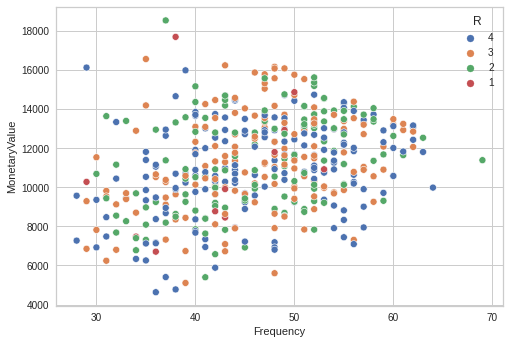

In [ ]:
cluster3 = data_for_model2[data_for_model2["cluster"] == 3]
sns.scatterplot(x = 'Frequency', y="MonetaryValue" , hue ="R", data = cluster3, palette="deep")

**Cluster 3**

Custer ini recency nya cukup bagus dilihat dari titik biru cukup banyak, dimana spent value nya juga cukup tinggi. Terutama di rentang 8000 - 15000. sangat berpotensi ditingkatkan menjadi Customer Gold.

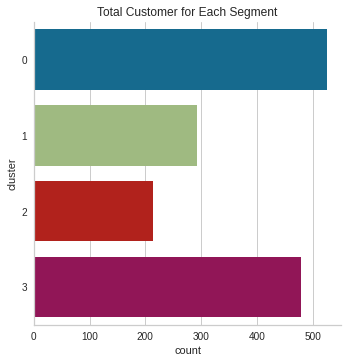

In [ ]:
sns.catplot(
    y = "cluster", 
    data = data_for_model2, 
    kind = "count", 
    height = 5
).ax.set_title("Total Customer for Each Segment");

Dari dua model yang dicoba (RFM dan K-Means) ini saya akan merekomendasikan K-Means dimana periode data transaksi yang dipakai hanya data transaksi setahun terakhir. alasannya sudah dijelaskan di awal analisa K-Means.

K-Means clusternya lebih mudah diinterpretasikan untuk mengevaluasi opportunity bisnis kedepan.

Kemudian dari segmentasi K-Means ini bisa dicek juga untuk masing-masing cluster produk atau subcategory apa yang paling sering dibeli. Serta bisa diketahui Region mana yang memiliki kemungkinan beli nya lebih besar sesuai data pareto.

**Cluster 3** bisa dijadikan opportunity baru untuk retensi agar bisa menjadi lebih loyal untuk lebih gencar memberikan promo karena secara monetary customer di cluster 3 value nya cukup besar meskipun frekuensi nya belum setinggi customer di **Cluster 1**

Sedangkan **Cluster 0** dimana potensi loyal customer nya masih di bawah Cluster 3. perlu dijadikan perhatian karena jumlahnya cukup banyak di atas 500 customer. yang sayang sekali kalau harus berhenti transaksi di Q2 dan Q3.

dan customer di **Cluster 1 dan 3** jika dilihat juga cukup banyak. Dengan jumlah hampir 500 Cust di cluster 3. Cluster 1 hampir 300 Customer. Ini menjadi peluang bagus untuk program loyalty Customer

**Sekian... Mohon feedbcak nya Mas Hadi Thanks :**)

# Link SLICE DECK [link text](
**  https://github.com/Fiska21/Customer-Segmentation-Case-1.git)**